In [ ]:
pip install pandas

In [ ]:
# this code calculates the frame (start and end) numbers and also filters the motion capture excel file accordingly 

import pandas as pd

# Motion capture start time make sure to note down the start time or find it in the information page of the motion capture excel file
start_time_seconds = 10 * 3600 + 47 * 60 + 23
# Define the frame rate
frame_rate = 60

# Define the time intervals for each module in hh:mm:ss format
time_intervals = [
    ("10:49:12", "10:50:36"),  # File 1
    ("10:50:36", "10:51:42"), #file 1 solve
    ("10:51:50", "10:52:55"),  # File 2
]
frame_intervals = []

for start, end in time_intervals:
    start_h, start_m, start_s = map(int, start.split(":"))
    end_h, end_m, end_s = map(int, end.split(":"))

    start_seconds = start_h * 3600 + start_m * 60 + start_s
    end_seconds = end_h * 3600 + end_m * 60 + end_s

    start_frame = int((start_seconds - start_time_seconds) * frame_rate)
    end_frame = int((end_seconds - start_time_seconds) * frame_rate)

    frame_intervals.append((start_frame, end_frame))

print("Frame intervals:", frame_intervals)

def label_modules(df):
    df['Module'] = None
    for i, (start_frame, end_frame) in enumerate(frame_intervals, start=1):
        df.loc[(df['Frame'] >= start_frame) & (df['Frame'] <= end_frame), 'Module'] = f'Module {i}'
    return df.dropna(subset=['Module'])


df_com = pd.read_excel('eye1_2.xlsx', engine='openpyxl')
df_com_labeled = label_modules(df_com)

# Save the final data New Excel File where you want to save the data
with pd.ExcelWriter('eye1_2_update.xlsx', engine='openpyxl') as writer:
    df_com_labeled.to_excel(writer, index=False)

print("Data processing completed! New file is created at the same folder as the python files and the HoloLens and the Motion capture excel file")

For holoLens data - Combine all the individual files and keep it in one file 
open excel app and open the text file using the app and seperate by using ']' and 
name the first column as 'data' and 2nd column as 'date'

In [ ]:
# this code assigns the frame numbers calculated to the HoloLens excel file.

import pandas as pd
import numpy as np


# Load the Hololens data
df_holo = pd.read_excel('holo/2_1.xlsx', engine='openpyxl')
df_holo['timestamp'] = pd.to_datetime(df_holo['date'].str.replace("\t", " "), format='[%m/%d/%Y %I:%M:%S %p')

# Initialize start times motion capture and HoloLens start time should be updated here
holo_start_time = pd.Timestamp('2023-01-01 10:49:12')
mocap_start_time = pd.Timestamp('2023-01-01 10:47:23')
    
initial_seconds_offset = (holo_start_time - mocap_start_time).total_seconds()
frame_counter = int(initial_seconds_offset * 60)  


def assign_frames(data_slice, start_frame):
    num_data_points = len(data_slice)
    frames = []
    if num_data_points > 0: 
        if num_data_points == 1:
            frames.append(start_frame)
        else:
            step = 60 / num_data_points
            for i in range(num_data_points):
                frames.append(int(round(start_frame + i * step)))
    return frames

frame_assignments = []
df_holo = df_holo.dropna(subset=['timestamp'])

unique_seconds = df_holo['timestamp'].dt.floor('s').unique()

unique_seconds = np.sort(unique_seconds)

for idx, time_sec in enumerate(unique_seconds):
    holo_slice = df_holo[df_holo['timestamp'].dt.floor('s') == time_sec]

    if not holo_slice.empty:
        frames_for_slice = assign_frames(holo_slice, frame_counter)
        frame_assignments.extend(frames_for_slice)
        
        if idx + 1 < len(unique_seconds):
            time_diff = (unique_seconds[idx + 1] - time_sec) / np.timedelta64(1, 's')
            frame_counter += int(time_diff) * 60 
        else:
            frame_counter += 60  
    else:
        print(f"No data for timestamp: {time_sec}")

df_holo['Frame'] = pd.Series(frame_assignments, index=df_holo.index)

# Save the Hololens data in a new file in the same folder
df_holo.to_excel('holo/2_1_1.xlsx', engine='openpyxl')


In [2]:
# this code merges both motion capture and HoloLens excel files into one file and saves in your updated file
# change your file names accordingly
# Add you working hololens excel file and motion capture excel file below
df_holo = pd.read_excel('holo/2_1_1.xlsx', engine='openpyxl')
df_com = pd.read_excel('eye1_2_update.xlsx', engine='openpyxl')

result_com = pd.merge(df_com, df_holo, on='Frame', how='left')
with pd.ExcelWriter('eye1_2_update.xlsx', engine='openpyxl') as writer:
    result_com.to_excel(writer, index=False)


NameError: name 'pd' is not defined

In [ ]:
# This code fills the empty records or cells in the updated merged motion capture excel file
def process_dataframe(df):
    df['date'] = df['date'].where(df['data'].ne('')).ffill()
    df['data'] = df['data'].where(df['data'].ne('')).ffill()
    df['timestamp'] = df['timestamp'].where(df['data'].ne('')).ffill()
    return df

file_name = 'eye1_2_update.xlsx'
with pd.ExcelFile(file_name) as xls:
    df_com = pd.read_excel(xls, engine='openpyxl')
    
df_com = process_dataframe(df_com)
# Write the modified data back to a new Excel file
output_file_name = 'eye1_2_update.xlsx'
with pd.ExcelWriter(output_file_name, engine='openpyxl') as writer:
    df_com.to_excel(writer, index=False)

In [ ]:
# this code adds a new column and add label like CP1, CP2 accordingly

import re
# Function to extract and generate labels
def label_data(row):
    global last_name
    name = row['temp_name']
    if name:
        short_name = ''.join(filter(str.isupper, name))
        if name != last_name:
            if name not in label_counter:
                label_counter[name] = 0
            label_counter[name] += 1
            last_name = name
        return f"{short_name}{label_counter[name]}"
    return None

def process_sheet(df):
    df['temp_name'] = df['data'].apply(lambda x: re.search(r'Name: (\w+)', str(x)).group(1) if re.search(r'Name: (\w+)', str(x)) else None)
    global label_counter, last_name
    label_counter = {}
    last_name = None
    df['label'] = df.apply(label_data, axis=1)
    return df.drop(columns=['temp_name'])

# Reading the excel file
file_path = "eye1_2_update.xlsx"
with pd.ExcelFile(file_path, engine='openpyxl') as xls:
    com_df = pd.read_excel(xls)

# Process each sheet
com_df = process_sheet(com_df)

# Save the modified data to the same file 
output_file_name = 'eye1_2_update.xlsx'
with pd.ExcelWriter(output_file_name, engine='openpyxl') as writer:
    com_df.to_excel(writer, index=False)


In [ ]:
# this code separates label into alphabets and numbers
import pandas as pd

# Load the Excel file with both sheets
xls = pd.ExcelFile('eye1_2_update.xlsx', engine='openpyxl')
sheets = {sheet_name: xls.parse(sheet_name) for sheet_name in xls.sheet_names}

# Apply the transformation to both sheets
for sheet_name, data in sheets.items():
    if sheet_name in ['Sheet1']:
        data['panel'] = data['label'].str.extract('([a-zA-Z]+)')
        data['count'] = data['label'].str.extract('(\d+)')
        sheets[sheet_name] = data

# Save both sheets back to the Excel file
with pd.ExcelWriter('eye1_2_update.xlsx', engine='openpyxl') as writer:
    for sheet_name, data in sheets.items():
        data.to_excel(writer, sheet_name=sheet_name, index=False)


In [ ]:
# this code assigns participant number to the file in a new column
import pandas as pd

# Define the file path
file_path = 'part4_1.xlsx'

all_sheets = pd.read_excel(file_path, sheet_name=None, engine='openpyxl')

# Define the participant number value you want to assign
participant_number = "4_1"

for sheet_name, data in all_sheets.items():
    data["participant number"] = participant_number

# Save the updated data back to the Excel file
with pd.ExcelWriter(file_path, engine='openpyxl') as writer:
    for sheet_name, data in all_sheets.items():
        data.to_excel(writer, sheet_name=sheet_name, index=False)

print("Participant number column added successfully!")


In [5]:
# this code does column selection

import pandas as pd
from openpyxl import load_workbook

# Load the transformed 'com' sheet from 'part19_2modulesholo.xlsx'
df = pd.read_excel('will_motion_v2.xlsx')

# Filter rows where the 'panel' column is "CP"
filtered_panel_df = df.loc[(df['panel'] == 'CP') | (df['Module'] == 'Module 8')]

# Filter columns as specified
filtered_df = filtered_panel_df[['Frame', 'CoM pos x', 'CoM pos y', 'CoM pos z', 'Module', 'date', 'data', 'label', 'panel', 'count', 'participant number']]

# Define the file path for the Excel file (combinedparticipants.xlsx)
file_path = 'will_motion_v2.xlsx'

# Use pandas ExcelWriter with the openpyxl engine, passing the book object
with pd.ExcelWriter(file_path, engine='openpyxl', mode='a', if_sheet_exists='overlay') as writer:
    # Write the filtered dataframe to a new sheet named '2_1'
    # If the sheet exists, it will be overwritten; otherwise, a new sheet will be created
    filtered_df.to_excel(writer, sheet_name='will_filtered', index=False)

# Confirm the operation's completion.
print("Transformations applied and filtered data appended successfully to 'combinedparticipants.xlsx' under the sheet '2_1'!")


Transformations applied and filtered data appended successfully to 'combinedparticipants.xlsx' under the sheet '2_1'!


In [9]:
# this code calculates are the required metrics to calculate the Slouching column
import pandas as pd

# Load the original dataset
df = pd.read_excel('Ellie_motion_v1.xlsx','Ellie_filtered')


# Decide on the baseline duration
baseline_duration_sec = 4
baseline_duration_rows = baseline_duration_sec * 60  # Assuming one row per second

# Establish the baseline using the average of the first few minutes of Module 1
global_baseline_com_x = df[df['Module'] == "Module 1"]['CoM pos x'].iloc[:baseline_duration_rows].mean()

def compute_max_deviation(df, global_baseline_com_x, x):
    # Calculate the absolute deviation for each frame
    df['deviation_from_baseline'] = df['CoM pos x'].apply(lambda val: abs(val - global_baseline_com_x))
    
    top_x_deviations = df['deviation_from_baseline'].nlargest(x)
    
    return top_x_deviations.mean()

x = 80 
max_deviation = compute_max_deviation(df, global_baseline_com_x, x)


def compute_slouching_score(row):
    deviation_com_x = abs(row['CoM pos x'] - global_baseline_com_x)
    
    # Normalize  [0, 100]
    normalized_score = 100 * (1 - (deviation_com_x / max_deviation))
    normalized_score = max(normalized_score, 0)  # Ensure score does not go below 0

    return normalized_score


# Apply the function to each row
df['slouching_score'] = df.apply(compute_slouching_score, axis=1)

# Save the updated dataframe to a new sheet in the existing Excel file
with pd.ExcelWriter('Ellie_motion_v1.xlsx', engine='openpyxl', mode='a') as writer:
    df.to_excel(writer, sheet_name='Elliescore', index=False)


print("Data appended in a new sheet 'willscore' in 'combinedparticipantsupdated.xlsx'")

average_scores = df.groupby('Module')['slouching_score'].mean()

print(average_scores)


Data appended in a new sheet 'willscore' in 'combinedparticipantsupdated.xlsx'
Module
Module 1    95.406098
Module 2    93.525564
Module 3    94.920555
Module 4    94.816280
Module 5    92.410611
Module 6    86.143096
Module 7    62.447806
Module 8    59.846872
Name: slouching_score, dtype: float64


0.002957359060022273


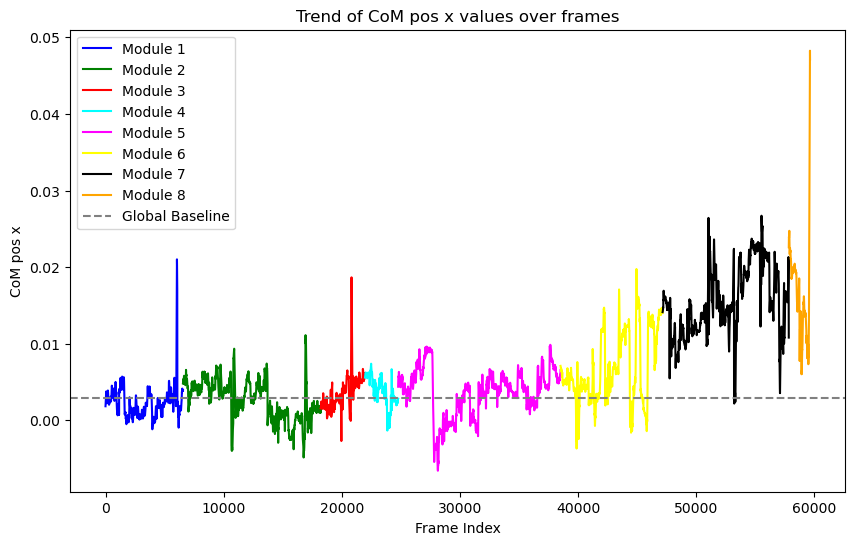

In [10]:
# just visualization 
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_excel('Ellie_motion_v1.xlsx','Elliescore')
global_baseline_com_x = df[df['Module'] == "Module 1"]['CoM pos x'].iloc[:baseline_duration_rows].mean()
print(global_baseline_com_x)
# Unique list of modules
modules = df['Module'].unique()

# Define a color list. If you have more modules, add more colors
colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'orange']

plt.figure(figsize=(10, 6))

# Plotting CoM pos x values for each module
for module, color in zip(modules, colors):
    module_df = df[df['Module'] == module]
    plt.plot(module_df.index, module_df['CoM pos x'], label=module, color=color)

plt.axhline(y=global_baseline_com_x, color='grey', linestyle='--', label='Global Baseline')
plt.title('Trend of CoM pos x values over frames')
plt.xlabel('Frame Index')
plt.ylabel('CoM pos x')
plt.legend()
plt.show()
